In [1]:
import stac_mjx 
import os
import numpy as np
import mediapy as media
import h5py
import gdown

from matplotlib import pyplot as plt
from pathlib import Path

# Enable XLA flags if on GPU
stac_mjx.enable_xla_flags()


/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(
/home/aaprasad/projects/con3trol/src/stac-mjx/stac_mjx/utils.py:16: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  if xla_bridge.get_backend().platform == "gpu":


In [2]:
gdown.download("https://drive.google.com/file/d/1uQZoo2wg7SiF-PL4rhKpQzYcoIWyxwZs/view?usp=sharing", "celegans_mocap.npz", fuzzy=True)

/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1uQZoo2wg7SiF-PL4rhKpQzYcoIWyxwZs
From (redirected): https://drive.google.com/uc?id=1uQZoo2wg7SiF-PL4rhKpQzYcoIWyxwZs&confirm=t&uuid=e7bb9a4a-1364-49cb-8b6b-4006d85122ed
To: /home/aaprasad/projects/con3trol/src/stac-mjx/demos/celegans_mocap.npz
100%|██████████| 305M/305M [00:02<00:00, 107MB/s]  


'celegans_mocap.npz'

In [3]:

# Choose parent directory as base path for data files
base_path = Path.cwd().parent
print(base_path)
# Load configs
cfg = stac_mjx.load_configs(base_path / "configs", "celegans_demo")
cfg

/home/aaprasad/projects/con3trol/src/stac-mjx
Config loaded and validated.


{'stac': {'fit_offsets_path': 'celegans_fit_offsets.h5', 'ik_only_path': 'celegans_ik_only.h5', 'n_fit_frames': 500, 'skip_fit_offsets': False, 'skip_ik_only': True, 'infer_qvels': True, 'n_frames_per_clip': 250, 'mujoco': {'solver': 'newton', 'iterations': 1, 'ls_iterations': 4}}, 'model': {'MJCF_PATH': 'models/celegans/celegans.xml', 'FTOL': 0.005, 'ROOT_FTOL': 1e-05, 'LIMB_FTOL': 1e-06, 'N_ITERS': 6, 'KP_NAMES': ['cl1', 'cl2', 'cl3', 'cl4', 'cl5', 'cl6', 'cl7', 'cl8', 'cl9', 'cl10', 'cl11', 'cl12', 'cl13', 'cl14', 'cl15', 'cl16', 'cl17', 'cl18', 'cl19', 'cl20', 'cl21', 'cl22', 'cl23', 'cl24', 'cl25'], 'KEYPOINT_MODEL_PAIRS': {'cl1': 'torso1_body', 'cl2': 'torso2_body', 'cl3': 'torso3_body', 'cl4': 'torso4_body', 'cl5': 'torso5_body', 'cl6': 'torso6_body', 'cl7': 'torso7_body', 'cl8': 'torso8_body', 'cl9': 'torso9_body', 'cl10': 'torso10_body', 'cl11': 'torso11_body', 'cl12': 'torso12_body', 'cl13': 'torso13_body', 'cl14': 'torso14_body', 'cl15': 'torso15_body', 'cl16': 'torso16_body

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 (422926, 75))

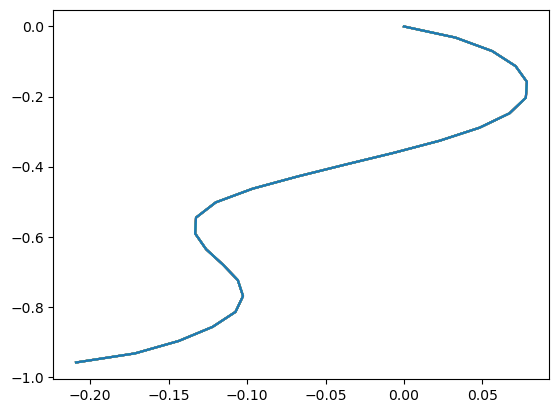

In [4]:

# Load data
sorted_kp_names = [f"cl{i}" for i in range(1, 26)]
microns_per_pixel = 1.44

kp_data_raw = np.load("./celegans_mocap.npz")["all_frames"]

kp_data_microns = kp_data_raw * microns_per_pixel
kp_data_meters = kp_data_microns * 1e-6
kp_data_rescaled = kp_data_microns * 1e-3
kp_data_units = kp_data_rescaled
kp_data_recentered = kp_data_units - kp_data_units[0,0,:]

z = np.zeros((kp_data_recentered.shape[0], kp_data_recentered.shape[1], 1)) #np.abs(np.random.normal(0, 1e-2, (kp_data_recentered.shape[0], kp_data_recentered.shape[1], 1))) 
kp_data_3d = np.concatenate([kp_data_recentered, z], axis=-1)

kp_data = kp_data_3d.reshape(kp_data_3d.shape[0], kp_data_3d.shape[1]*kp_data_3d.shape[2])

plt.plot(kp_data[0,::3], kp_data[0,1::3]) 
for i in range(10):
    plt.plot(kp_data[0,::3], kp_data[0,1::3])
kp_data[0,0::3], kp_data.shape

In [5]:

# Run stac
fit_path, ik_only_path = stac_mjx.run_stac(
 cfg,
 kp_data, 
 sorted_kp_names, 
 base_path=base_path,
)

Running fit. Mocap data shape: (500, 75)


/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "ellipsoid1" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "ellipsoid2" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "ellipsoid3" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/site-packages/mujoco/mjx/_src/mesh.py:141:

ROOT_OPTIMIZATION_KEYPOINT not specified, skipping Root Optimization.
Calibration iteration: 1/6
Pose Optimization:
Pose Optimization done in 163.56149792671204
Frame 1 done in 88.83541345596313 with a final error of 0.0
Frame 2 done in 0.14677858352661133 with a final error of 0.0
Frame 3 done in 0.14684677124023438 with a final error of 0.0
Frame 4 done in 0.1493825912475586 with a final error of 0.0
Frame 5 done in 0.1463792324066162 with a final error of 0.0
Frame 6 done in 0.14745640754699707 with a final error of 0.0
Frame 7 done in 0.14908719062805176 with a final error of 0.0
Frame 8 done in 0.14605140686035156 with a final error of 0.0
Frame 9 done in 0.14776039123535156 with a final error of 0.0
Frame 10 done in 0.14900922775268555 with a final error of 0.0
Frame 11 done in 0.14759492874145508 with a final error of 0.0
Frame 12 done in 0.14441418647766113 with a final error of 0.0
Frame 13 done in 0.14648842811584473 with a final error of 0.0
Frame 14 done in 0.14954400062561

In [7]:
data_path = base_path / "celegans_fit_offsets.h5"


save_path = base_path / f"registration_celegans.mp4"
cfg, frames = stac_mjx.viz_stac(data_path,
                                cfg.stac.n_fit_frames,
                                save_path, 
                                start_frame=0, 
                                camera="track", 
                                base_path=Path.cwd().parent,
                                show_marker_error=True)
media.show_video(frames, fps=cfg.model.RENDER_FPS)

0it [00:00, ?it/s]/home/aaprasad/miniforge3/envs/stac-mjx/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
500it [00:05, 96.34it/s] 
